<a href="https://colab.research.google.com/gist/jteichma/4d9c0079dbf4e9c3cdff3fd1befabd23/deep_hedging_bs_conditionalrewards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Stock Prices under the Heston Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Heston Model

### [Formula](https://en.wikipedia.org/wiki/Heston_model)

The price of the asset $S_t$ is determined by a stochastic process:

<center> $dS_{t}=\mu S_{t}\,dt+{\sqrt  {\nu_{t}}}S_{t}\,dW_{t}^{S}$ </center>

The instantaneous variance $\nu_t$ is a CIR process:

<center> $d\nu_{t}=\kappa (\theta -\nu_{t})\,dt+\xi {\sqrt  {\nu_{t}}}\,dW_{t}^{{\nu }}$ </center>

where $W_{t}^{S},W_{t}^{\nu }$ are Wiener processes (continuous random walks) with correlation $\rho$.

The parameters in the above equations represent the following:
- $\mu$ is the rate of return of the asset.
- $\theta$ is the long variance, or long run average price variance; as $t$ tends to infinity, the expected value of $\nu_t$ tends to $\theta$.
- $\kappa$ is the rate at which $\nu_t$ reverts to $\theta$.
- $\xi$ is the volatility of the volatility, or 'vol of vol', and determines the variance of $\nu_t$.

If $2\kappa \theta >\xi ^{2}$ (Feller condition), then the process $\nu_t$ is strictly positive.


### Discretization
Forward Euler for Heston model

<center> $\nu_{t} = \nu_{t-1} + \kappa (\theta -\nu_{t-1})\frac{T}{N} + \xi{\sqrt{|\nu_{t-1}|}}\sqrt{\frac{T}{N}} Z_{t}^{\nu}$ </center>

<center> $\log(S_t)= \log(S_{t-1}) -\frac{\nu_{t}^2}{2} \frac{T}{N} + \nu_{t} \sqrt{\frac{T}{N}} Z_{t}^{S}$ </center>


### Implementation Decisions (to be made)
- Initialization - does it matter in our case?
- Parameter tuning - maybe it doesn't matter in our case either
- What to do when v < 0? abs, trunc? Do we apply it to all v's in the formula?

### Some References
- https://www.degruyter.com/document/doi/10.1515/math-2017-0058/html#:~:text=The%20main%20parameters%20of%20interest,increases%20the%20prices%20of%20options
- https://www.quantstart.com/articles/Heston-Stochastic-Volatility-Model-with-Euler-Discretisation-in-C/
- https://arxiv.org/pdf/1502.02963.pdf
- https://www.valpo.edu/mathematics-statistics/files/2015/07/Estimating-Option-Prices-with-Heston%E2%80%99s--Stochastic-Volatility-Model.pdf

In [2]:
## Dimensions
m = 1           # dimention of output
Ktrain = 10**5  # number of training models

N = 100         # time disrectization
T = 1           # maturity

## Parameters
corr = -0.3     # correlation between the two process
kappa = 0.9     # kappa: mean reversion rate
theta = 0.2     # theta: long-term volatility
xi = 0.2        # xi: volatility of volatility

## Initialization - could have other values
S0 = 1 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))
S = [S0]
v = [v0]

## Simulation - generate volatility and stock price from day 0 to day N

v_curr = v0; S_curr = S0

for i in range(N):
    
    # Simulate standard normal random variables
    Z1_i = np.random.normal(0,1,(Ktrain,m))
    Z2_i = np.random.normal(0,1,(Ktrain,m))
    
    # Generate correlated Brownian motions
    WS_curr = np.sqrt(T/N)*Z1_i
    Wv_curr = np.sqrt(T/N)*(corr*Z1_i + np.sqrt(1-corr**2)*Z2_i)
    
    # Calculate volatility and stock price
    # Adjustment: np.abs(v_curr) for np.sqrt() in the last term
    v_new = v_curr + kappa*(theta-v_curr)*T/N + xi*np.sqrt(np.abs(v_curr))*Wv_curr
    S_new = np.exp(np.log(S_curr) - v_new**2/2*T/N + v_new*WS_curr)
    
    v_curr = v_new; S_curr = S_new
    
    # Append the results to the arrays of each day's value
    v += [v_new]; S += [S_new]
    

0.9733567439003933
0.19875929616898866


(array([8.0000e+00, 1.1500e+02, 4.4600e+02, 1.5900e+03, 4.0010e+03,
        7.9120e+03, 1.2565e+04, 1.6298e+04, 1.7033e+04, 1.4695e+04,
        1.0698e+04, 6.9060e+03, 3.8310e+03, 2.0620e+03, 9.7800e+02,
        4.6300e+02, 2.0400e+02, 1.0400e+02, 4.7000e+01, 2.2000e+01,
        1.1000e+01, 8.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.2693528 , 0.35193771, 0.43452263, 0.51710755, 0.59969247,
        0.68227739, 0.76486231, 0.84744722, 0.93003214, 1.01261706,
        1.09520198, 1.1777869 , 1.26037182, 1.34295673, 1.42554165,
        1.50812657, 1.59071149, 1.67329641, 1.75588133, 1.83846624,
        1.92105116, 2.00363608, 2.086221  , 2.16880592, 2.25139084,
        2.33397575]),
 <a list of 25 Patch objects>)

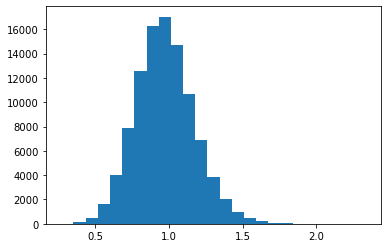

In [3]:
print(np.mean(S[N]))
print(np.std(S[N]))
plt.hist(S[N], bins = 25)

## Comparison - Constant Volatility

In [4]:
## Dimensions
m = 1           # dimention of output
Ktrain = 10**5  # number of training models

N = 100         # time disrectization
T = 1           # maturity

## Parameters
corr = -0.3     # correlation between the two process
kappa = 0.7     # kappa: mean reversion rate
theta = 0.2     # theta: long-term volatility
xi = 0.4        # xi: volatility of volatility


## Initialization - could have other values
S0 = 1 * np.ones((Ktrain,m))
v0 = theta * np.ones((Ktrain,m))
S = [S0]
v = [v0]

## Simulation
# generate volatility and stock price from day 0 to day N

v_curr = v0; S_curr = S0

for i in range(N):
    
    # Simulate standard normal random variables
    Z1_i = np.random.normal(0,1,(Ktrain,m))
    WS_curr = np.sqrt(T/N)*Z1_i
    S_new = np.exp(np.log(S_curr) - v0**2/2*T/N + v0*WS_curr)
    S_curr = S_new
    
    # Append the results to the arrays of each day's value
    S += [S_new]
    


1.000056821255643
0.2013204236725427


(array([2.7000e+01, 2.4400e+02, 1.0620e+03, 3.3290e+03, 6.9270e+03,
        1.0654e+04, 1.3698e+04, 1.4714e+04, 1.3411e+04, 1.1307e+04,
        8.6990e+03, 6.0280e+03, 3.9320e+03, 2.4870e+03, 1.4780e+03,
        8.8800e+02, 5.3700e+02, 2.7400e+02, 1.6900e+02, 6.5000e+01,
        3.9000e+01, 1.7000e+01, 8.0000e+00, 4.0000e+00, 2.0000e+00]),
 array([0.41802743, 0.48871269, 0.55939795, 0.6300832 , 0.70076846,
        0.77145372, 0.84213897, 0.91282423, 0.98350949, 1.05419474,
        1.12488   , 1.19556526, 1.26625052, 1.33693577, 1.40762103,
        1.47830629, 1.54899154, 1.6196768 , 1.69036206, 1.76104731,
        1.83173257, 1.90241783, 1.97310308, 2.04378834, 2.1144736 ,
        2.18515885]),
 <a list of 25 Patch objects>)

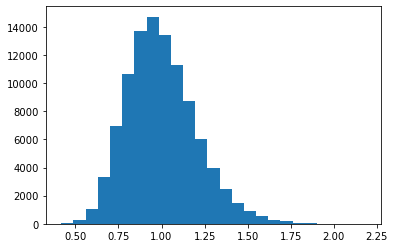

In [5]:
print(np.mean(S[N]))
print(np.std(S[N]))
plt.hist(S[N], bins = 25)